# Strategic Thinking for Data Analysis - CA3

### Data Source

The source of the datasets is Kaggle, which provides public datasets for analysis. Two datasets generated from photovoltaic energy generation and temperature sensor data from two solar plants in India will be used. These datasets contain 34 days of generation data from the year 2020.

In order to facilitate and simplify the analysis, data from only one of the Photovoltaic Plants will be used.

**Dataset names:** Plant_1_Generation_Data and Plant_1_Weather_Data.


### Variable Identification
#### Generation data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals.
- PLANT_ID - Plant ID number.
- INVERTER - Inverter id.
- DC_POWER - Amount of DC power generated by the Inverter in this 15 minute interval (kW).
- AC_POWER - Amount of AC power generated by the Inverter in this 15 minute interval (kW).
- DAILY_YIELD - Daily yield is a cumulative sum of power generated on that day, till that point in time.
- TOTAL_YIELD - This is the total yield for the inverter till that point in time.

#### Tempearture and Solar Irradiation data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals.
- Plant ID - this will be common for the entire file.
- SENSOR - Stands for the sensor panel id.
- AMBIENT_TEMPERATURE - This is the ambient temperature at the plant.
- MODULE_TEMPERATURE - There is a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.
- IRRADIATION - Amount of irradiation for the 15 minute interval.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")


## Data Loading

In [2]:
# Loading the Generation Data set 1
df_gen = pd.read_csv('Data\Plant_1_Generation_Data.csv')
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [3]:
# Loading the Weather Data set 1
df_wth = pd.read_csv('Data\Plant_1_Weather_Sensor_Data.csv')
df_wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


### Converting the 'DATE_TIME' column to datetime type

In [4]:
df_gen['DATE_TIME']= pd.to_datetime(df_gen['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB


In [5]:
df_wth['DATE_TIME']= pd.to_datetime(df_wth['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


### Aggregation into Time Intervals

Preparation and organization for generation data analysis, aggregating them into larger time intervals.
Conversion of the time column to datetime formats and separating the date and time into distinct columns to facilitate analysis.

#### Generation Dataframe

In [6]:
plant1_data=df_gen

# Group the data by the column 'DATE_TIME' and aggregate
# outhers columns by summing their values
plant1_data = plant1_data.groupby('DATE_TIME')[['DC_POWER',
                                                'AC_POWER', 
                                                'DAILY_YIELD',
                                                'TOTAL_YIELD']].agg('sum')

# Reset the index to make 'DATE_TIME' a regular column again
plant1_data = plant1_data.reset_index()

# Convert the 'DATE_TIME' column to datetime format,
# coercing errors to NaT (Not a Time) for any invalid values
plant1_data['DATE_TIME'] = pd.to_datetime(plant1_data['DATE_TIME'], errors='coerce')

# Storing DATE_TIME' in a new column 'time'
plant1_data['time'] = plant1_data['DATE_TIME'].dt.time

# Convert the 'DATE_TIME' column to datetime format and store in a new column 'date'
plant1_data['date'] = pd.to_datetime(plant1_data['DATE_TIME'].dt.date)

#### Temperature Dataframe

In [7]:
plant1_sensor = df_wth

# Convert the 'DATE_TIME' column to datetime format,
# coercing errors to NaT (Not a Time) for any invalid values
plant1_sensor['DATE_TIME'] = pd.to_datetime(plant1_sensor['DATE_TIME'], errors='coerce')

# Storing DATE_TIME' in a new column 'time
plant1_sensor['time'] = pd.to_datetime(plant1_sensor['DATE_TIME']).dt.time

# Convert the 'DATE_TIME' column to datetime format and store in a new column 'date'
plant1_sensor['date'] = pd.to_datetime(pd.to_datetime(plant1_sensor['DATE_TIME']).dt.date)

### Merging Dataframes

Merging the plant1_sensor and plant1_data DataFrames using the 'DATE_TIME' column as the key. This results in a new DataFrame called power_sensor that contains all columns from both DataFrames, but combined based on the timestamp. Removing redundant columns from the power_sensor DataFrame, which were created as a result of merging the DataFrames. These columns are removed because they are duplicates.

In [8]:
# Merge the DataFrames plant1_sensor and plant1_data based on the 'DATE_TIME' column
power_sensor = plant1_sensor.merge(plant1_data, left_on='DATE_TIME', right_on='DATE_TIME')

# Delete unnecessary columns from the merged DataFrame
del power_sensor['date_x']
del power_sensor['date_y']
del power_sensor['time_x']
del power_sensor['time_y']

### Verify Data Type

In [9]:
power_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   PLANT_ID             3157 non-null   int64         
 2   SOURCE_KEY           3157 non-null   object        
 3   AMBIENT_TEMPERATURE  3157 non-null   float64       
 4   MODULE_TEMPERATURE   3157 non-null   float64       
 5   IRRADIATION          3157 non-null   float64       
 6   DC_POWER             3157 non-null   float64       
 7   AC_POWER             3157 non-null   float64       
 8   DAILY_YIELD          3157 non-null   float64       
 9   TOTAL_YIELD          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 246.8+ KB


In [10]:
power_sensor.shape

(3157, 10)

In [11]:
power_sensor.describe()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,3157,3157.0,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3.157000e+03
mean,2020-06-01 06:41:41.298701568,4135001.0,25.560257,31.175453,0.230103,68560.019625,6704.830534,71798.457968,1.520288e+08
min,2020-05-15 00:00:00,4135001.0,20.398505,18.140415,0.000000,0.000000,0.000000,0.000000,2.654004e+07
25%,2020-05-23 23:15:00,4135001.0,22.739895,21.130249,0.000000,0.000000,0.000000,90.732143,1.521018e+08
50%,2020-06-01 12:30:00,4135001.0,24.680324,24.801971,0.027748,8430.196429,814.880357,66068.000000,1.535336e+08
75%,2020-06-09 18:00:00,4135001.0,27.941221,41.449481,0.451576,140409.892856,13752.112500,129444.625000,1.549952e+08
max,2020-06-17 23:45:00,4135001.0,35.252486,65.545714,1.221652,298937.785710,29150.212499,193770.000000,1.561428e+08
std,NaN,0.0,3.351059,12.272685,0.301348,88055.843520,8604.217954,65979.013517,1.038196e+07


### Outliers em Variáveis Chave

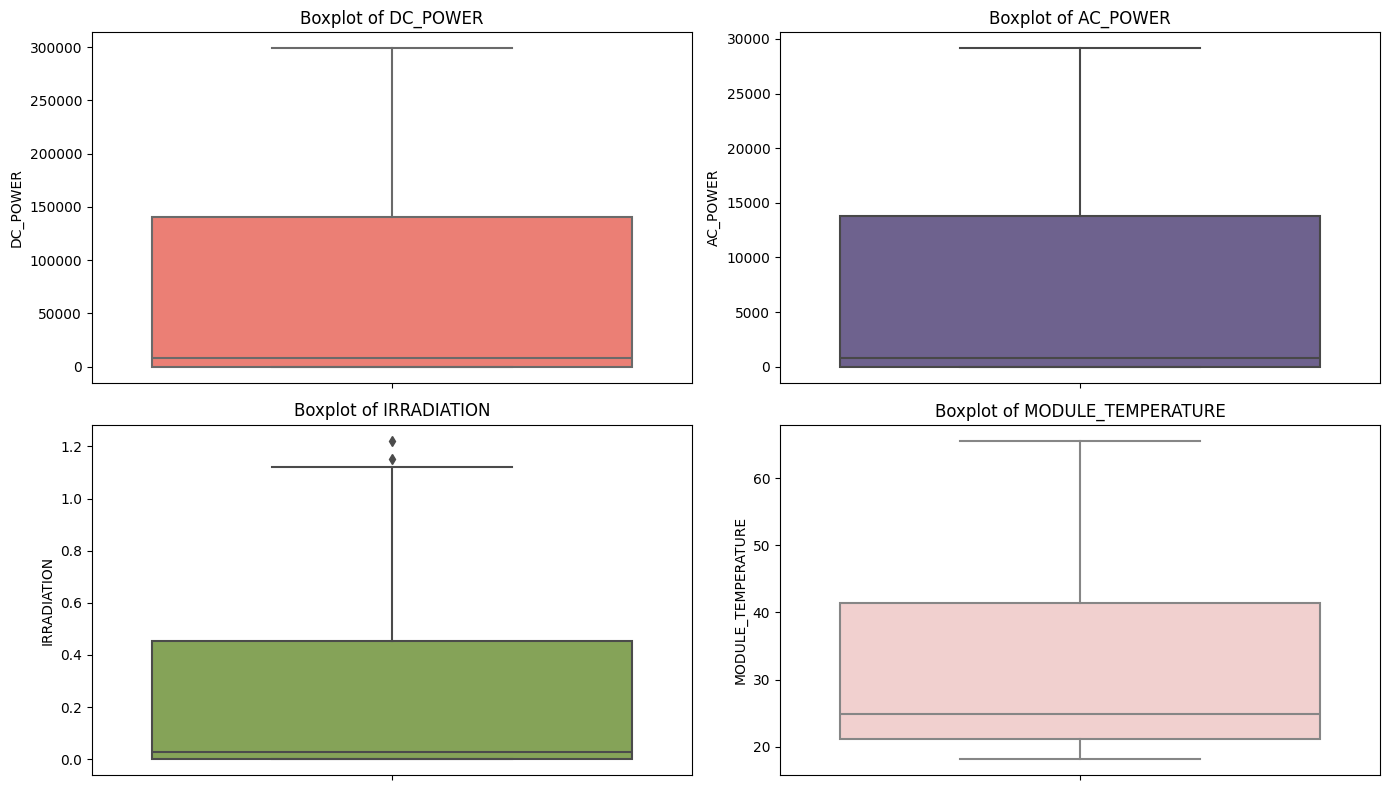

In [12]:
# Variáveis a verificar
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']
features = ['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=power_sensor, y=feature, color=colors[i-1])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

 ### Scatter Plot com o Tempo
 Útil para entender outliers ao longo da série

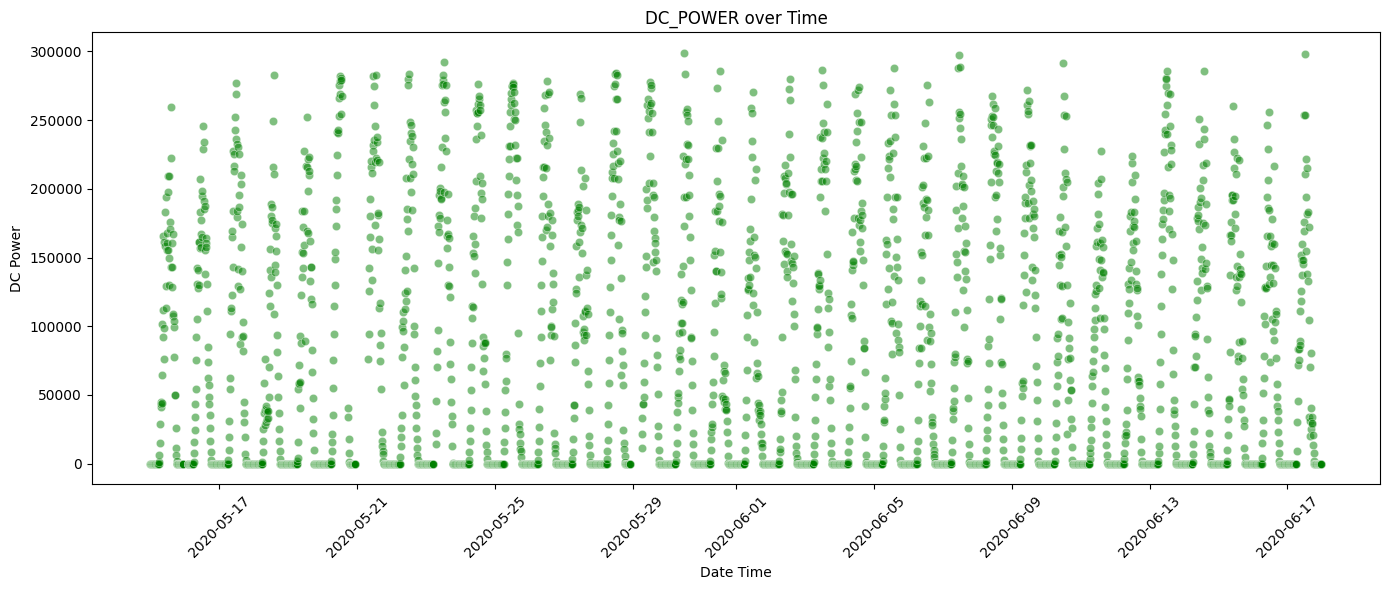

In [13]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=power_sensor, x='DATE_TIME', y='DC_POWER', color='green', alpha=0.5)
plt.title('DC_POWER over Time')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Checking for Null values

In [14]:
power_sensor.isnull().sum()

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
dtype: int64

## Pré Processamento dos Dados

## Descriptive Statistics
Finding Mean, Median, Min and Max Values

#### Line plot com Média de DC_POWER por Dia

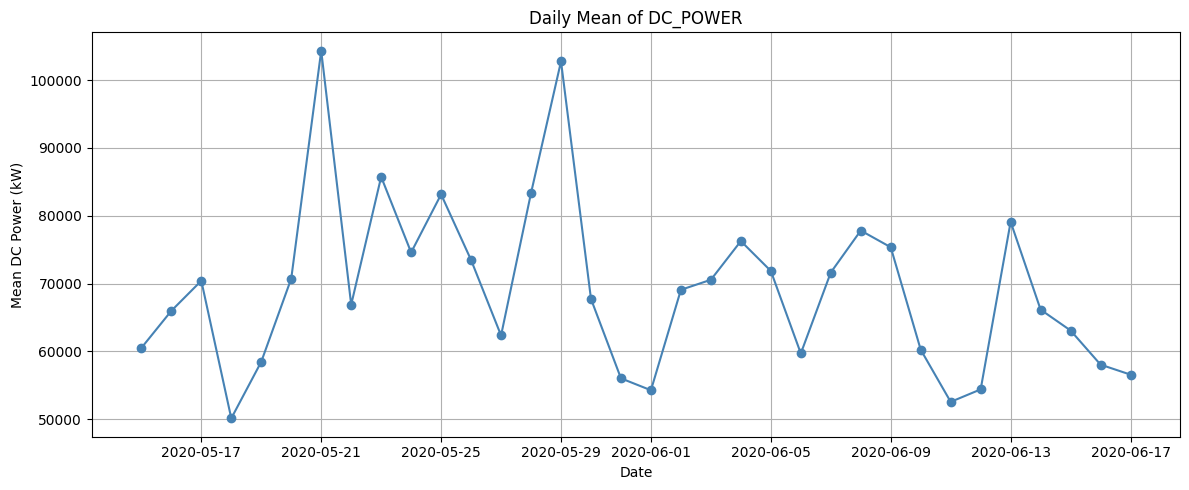

In [15]:
# Ensure datetime column is in datetime format
power_sensor['DATE_TIME'] = pd.to_datetime(power_sensor['DATE_TIME'])

# Create a new column for date only (removing time component)
power_sensor['DATE'] = power_sensor['DATE_TIME'].dt.date

# Group by DATE and calculate mean
daily_mean = power_sensor.groupby('DATE')['DC_POWER'].mean()

# Plot daily mean of DC_POWER
plt.figure(figsize=(12, 5))
daily_mean.plot(marker='o', color='steelblue')
plt.title('Daily Mean of DC_POWER')
plt.xlabel('Date')
plt.ylabel('Mean DC Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Line plot com Mediana de DC_POWER por Dia

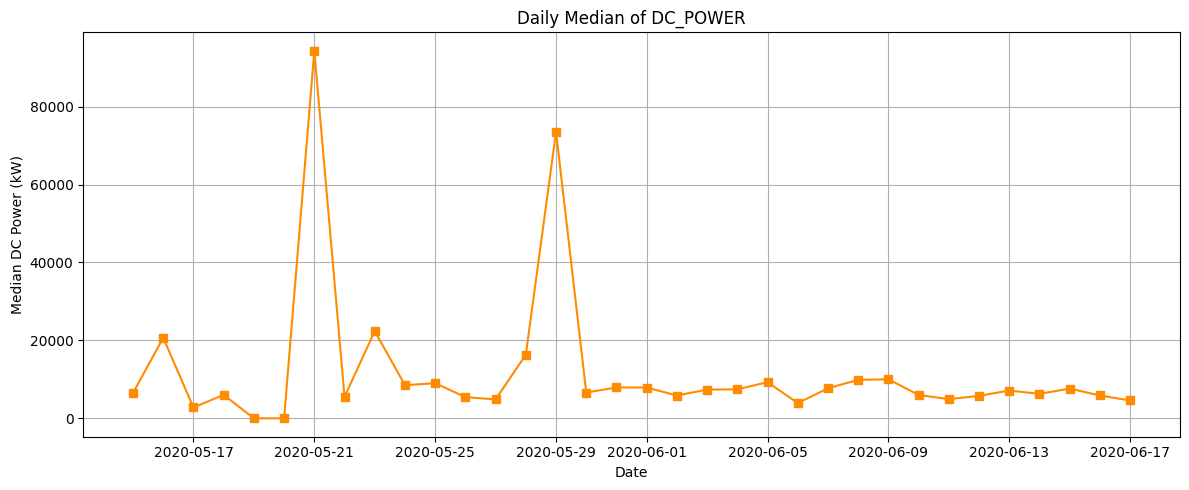

In [16]:
# Group by DATE and calculate median
daily_median = power_sensor.groupby('DATE')['DC_POWER'].median()

# Plot daily median of DC_POWER
plt.figure(figsize=(12, 5))
daily_median.plot(marker='s', color='darkorange')
plt.title('Daily Median of DC_POWER')
plt.xlabel('Date')
plt.ylabel('Median DC Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Function imprimir_valores_unicos()
A function that prints the unique values of each variable.

In [17]:
def imprimir_valores_unicos(data_f):
    for coluna in data_f.columns:
        valores_unicos = data_f[coluna].unique()
        print(f"  {coluna} = {valores_unicos}")

In [18]:
imprimir_valores_unicos(power_sensor)

  DATE_TIME = <DatetimeArray>
['2020-05-15 00:00:00', '2020-05-15 00:15:00', '2020-05-15 00:30:00',
 '2020-05-15 00:45:00', '2020-05-15 01:00:00', '2020-05-15 01:15:00',
 '2020-05-15 01:30:00', '2020-05-15 01:45:00', '2020-05-15 02:00:00',
 '2020-05-15 02:15:00',
 ...
 '2020-06-17 21:30:00', '2020-06-17 21:45:00', '2020-06-17 22:00:00',
 '2020-06-17 22:15:00', '2020-06-17 22:30:00', '2020-06-17 22:45:00',
 '2020-06-17 23:00:00', '2020-06-17 23:15:00', '2020-06-17 23:30:00',
 '2020-06-17 23:45:00']
Length: 3157, dtype: datetime64[ns]
  PLANT_ID = [4135001]
  SOURCE_KEY = ['HmiyD2TTLFNqkNe']
  AMBIENT_TEMPERATURE = [25.18431613 25.08458867 24.9357526  ... 22.00827464 21.96949473
 21.90928767]
  MODULE_TEMPERATURE = [22.8575074  22.76166787 22.59230553 ... 20.70921136 20.7349628
 20.4279724 ]
  IRRADIATION = [0.00000000e+00 8.62721241e-04 5.88695719e-03 ... 2.34457015e-02
 7.00688981e-03 3.90831153e-05]
  DC_POWER = [    0.           942.14880953  6142.1011903  ... 13312.0000002
  7450.62

In [19]:
power_sensor.nunique()

DATE_TIME              3157
PLANT_ID                  1
SOURCE_KEY                1
AMBIENT_TEMPERATURE    3157
MODULE_TEMPERATURE     3157
IRRADIATION            1755
DC_POWER               1688
AC_POWER               1688
DAILY_YIELD            1777
TOTAL_YIELD            1734
DATE                     34
dtype: int64

### Variable adjustment

#### Droping variables

In [20]:
power_sensor.drop(columns=['PLANT_ID'], inplace=True)
power_sensor.drop(columns=['SOURCE_KEY'], inplace=True)

In [21]:
power_sensor

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE
0,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15
1,2020-05-15 00:15:00,25.084589,22.761668,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15
2,2020-05-15 00:30:00,24.935753,22.592306,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15
3,2020-05-15 00:45:00,24.846130,22.360852,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15
4,2020-05-15 01:00:00,24.621525,22.165423,0.0,0.0,0.0,0.000000,150761642.0,2020-05-15
...,...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,22.150570,21.480377,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17
3153,2020-06-17 23:00:00,22.129816,21.389024,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17
3154,2020-06-17 23:15:00,22.008275,20.709211,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17
3155,2020-06-17 23:30:00,21.969495,20.734963,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17


In [22]:
power_sensor.nunique()

DATE_TIME              3157
AMBIENT_TEMPERATURE    3157
MODULE_TEMPERATURE     3157
IRRADIATION            1755
DC_POWER               1688
AC_POWER               1688
DAILY_YIELD            1777
TOTAL_YIELD            1734
DATE                     34
dtype: int64

In [23]:
power_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   AMBIENT_TEMPERATURE  3157 non-null   float64       
 2   MODULE_TEMPERATURE   3157 non-null   float64       
 3   IRRADIATION          3157 non-null   float64       
 4   DC_POWER             3157 non-null   float64       
 5   AC_POWER             3157 non-null   float64       
 6   DAILY_YIELD          3157 non-null   float64       
 7   TOTAL_YIELD          3157 non-null   float64       
 8   DATE                 3157 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 222.1+ KB


### Seleção automática de features
Selecionar as features mais relevantes para prever DC_POWER, usando SelectKBest com teste estatístico (f_regression).  
Score: quanto maior o valor, mais relevante é a feature para prever DC_POWER, segundo o teste F (usado em regressão).

In [24]:
# Separando target e features
y = power_sensor['DC_POWER']

# remove target e timestamp
X = power_sensor.drop(['DC_POWER', 'DATE_TIME'], axis=1) 

# Se houver variáveis categóricas, faça encoding (exemplo: One-Hot)
X_encoded = pd.get_dummies(X, drop_first=True)

In [25]:
selector = SelectKBest(score_func=f_regression, k='all')
X_new = selector.fit_transform(X_encoded, y)

# Mostrando os scores das features
import pandas as pd

feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

display(feature_scores)

,Feature,Score
3,AC_POWER,5.623727e+08
2,IRRADIATION,3.878384e+05
1,MODULE_TEMPERATURE,3.803542e+04
0,AMBIENT_TEMPERATURE,3.509692e+03
5,TOTAL_YIELD,3.605868e+01
4,DAILY_YIELD,2.719826e+01
19,DATE_2020-05-29,1.098366e+01
11,DATE_2020-05-21,1.098243e+01
8,DATE_2020-05-18,4.341538e+00
13,DATE_2020-05-23,3.485900e+00


#### Principais insights dos Scores Features
561 milhões - AC_POWER é extemamente correlacionada com DC_POWER, o que é esperado, pois ambas representam potência elétrica em diferentes partes do sistema. Pode haver colinearidade.  
387 mil - IRRADIATION é Muito importante, pois a radiação solar influencia diretamente a produção de energia.  
38 mil - MODULE_TEMPERATURE é muito relevantes também. Afeta a eficiência dos módulos solares — mais calor pode reduzir o desempenho, o que faz sentido técnico.  
AMBIENT_TEMPERATURE: Pode estar correlacionada com a MODULE_TEMPERATURE, mas é menos diretamente associada à performance do painel.  
TOTAL_YIELD e DAILY_YIELD: São métricas acumulativas, então seu valor para previsão depende da abordagem. Não são muito relevantes isoladamente, mas podem ser úteis para modelagem se combinadas com outras variáveis.

## Exploratory Data Analysis

### Scatter Plot and Mean DC Power

Grafico que mostra DC_POWER ao longo do dia e sua media no periodo total. Os pontos de DC_POWER pode revelar a variabilidade diária, possíveis picos, anomalias ou períodos com falhas. A linha mostra a Média de DC_POWER agrupado por horario, o que ajuda a visualizar tendências gerais e sazonalidade diária.

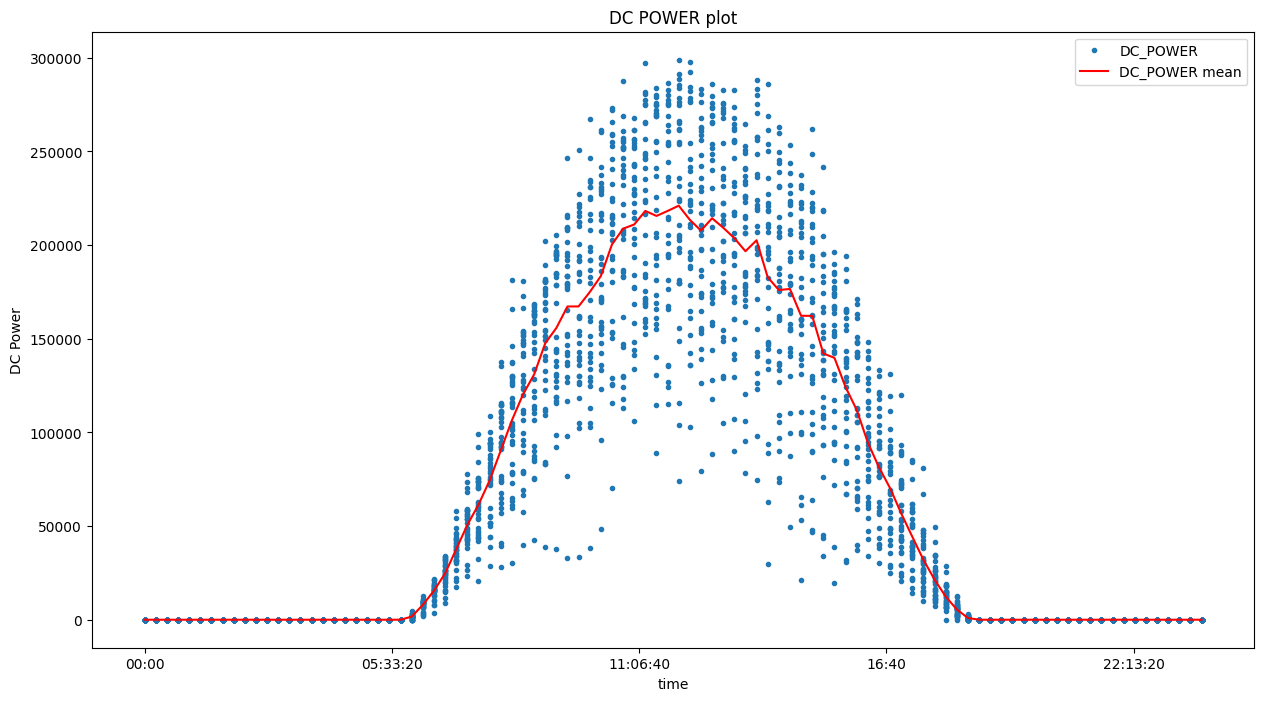

In [26]:
# Plot the 'DC_POWER' column vs the 'time' column of plant1_data
plant1_data.plot(x='time', y='DC_POWER', style='.', figsize=(15, 8))

# Group the data by 'time' and calculate the mean of 'DC_POWER' for each time
plant1_data.groupby('time')['DC_POWER'].agg('mean').plot(legend=True, label='DC_POWER mean', color='red')

# Adding labels and title
plt.ylabel('DC Power')
plt.title('DC POWER plot')

# Display the plot
plt.show()


### Heatmap
Correlação entre variáveis com heatmap, Mostra relações entre variáveis, destacando o que influencia DC_POWER.

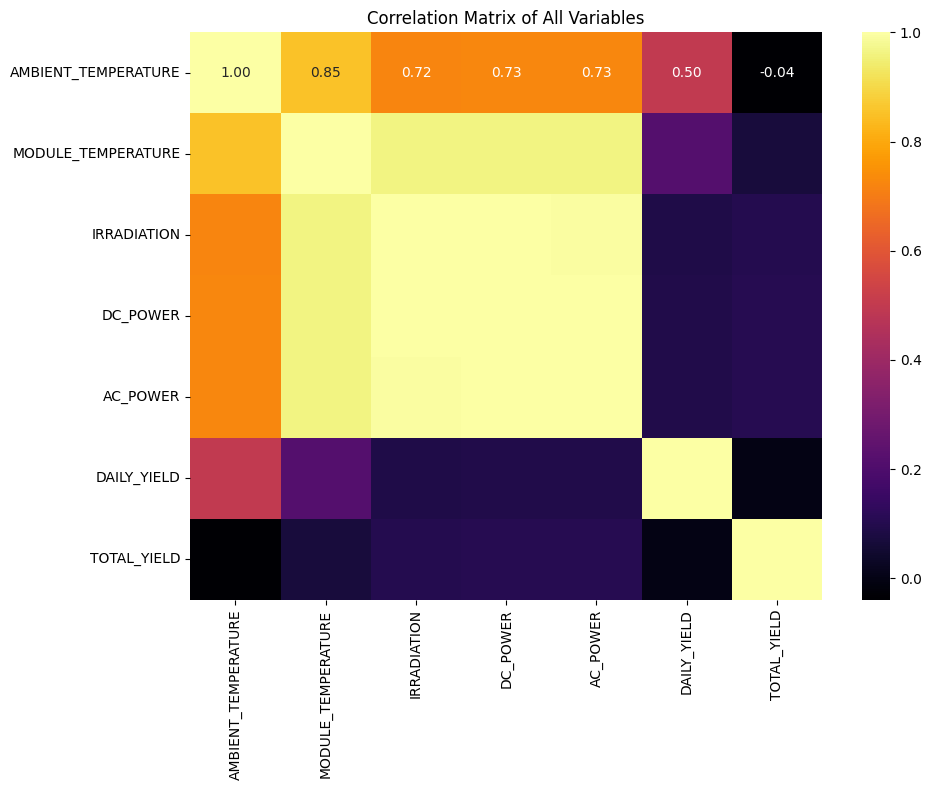

In [27]:
plt.figure(figsize=(10, 8))
correlation_matrix = power_sensor.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', fmt=".2f")
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

### Matrix of Scatter Plots of Key Variables

Exploring relationships and correlations between key variables in the dataset, to quickly understand how variables interact with each other.

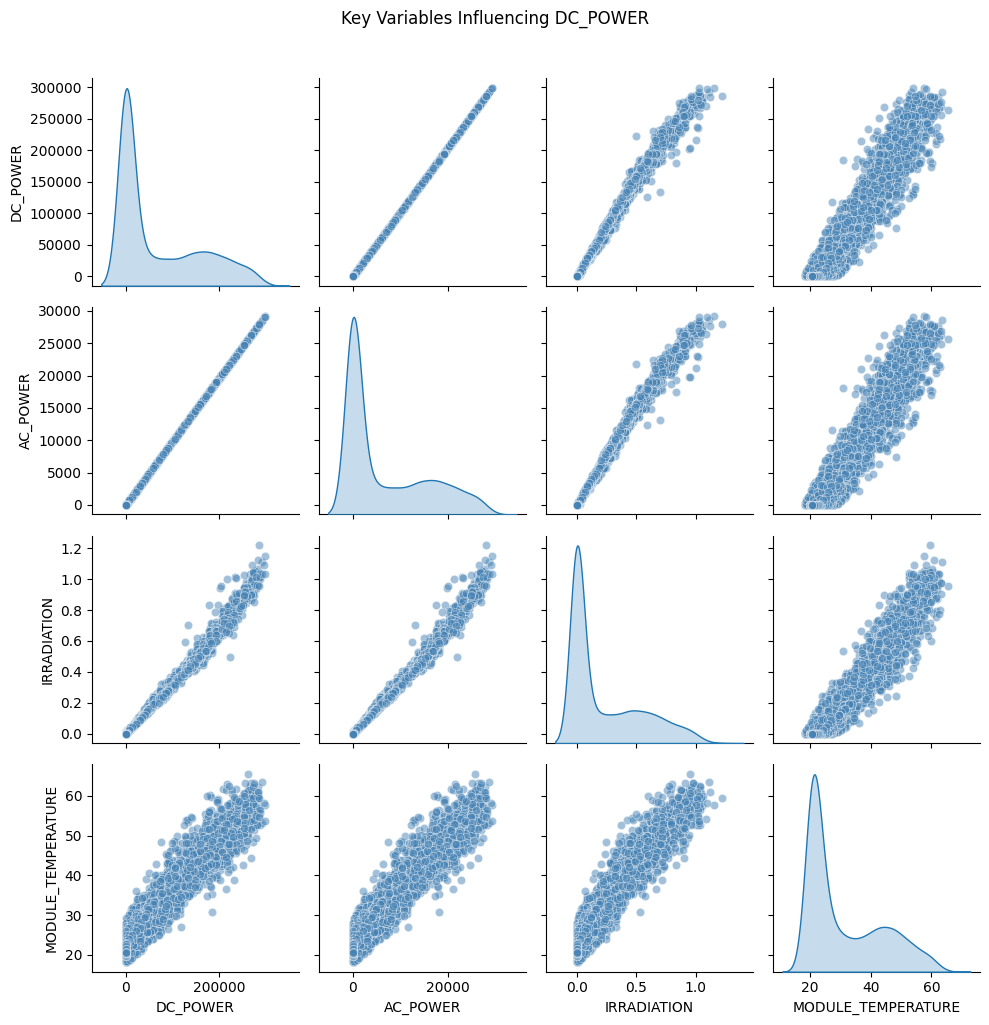

In [28]:
key_vars = ['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']
sns.pairplot(power_sensor[key_vars], kind='scatter', diag_kind='kde',  plot_kws={'color':'steelblue','alpha':0.5})
plt.suptitle('Key Variables Influencing DC_POWER', y=1.02)
plt.tight_layout()
plt.show()

### DC Power vs Irradiation

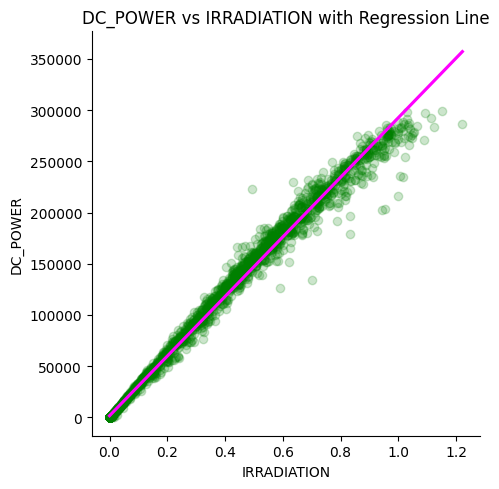

In [29]:
sns.lmplot(x='IRRADIATION', y='DC_POWER', data=power_sensor, scatter_kws={'color':'green', 'alpha':0.2}, line_kws={'color':'magenta'})
plt.title('DC_POWER vs IRRADIATION with Regression Line')
plt.tight_layout()
plt.show()

### Daily Yield

### Daily Yield and AC-DC Power
Vizualizar a relação entre AC_POWER e DC_POWER durante as horas do dia.

Text(0, 0.5, 'kW')

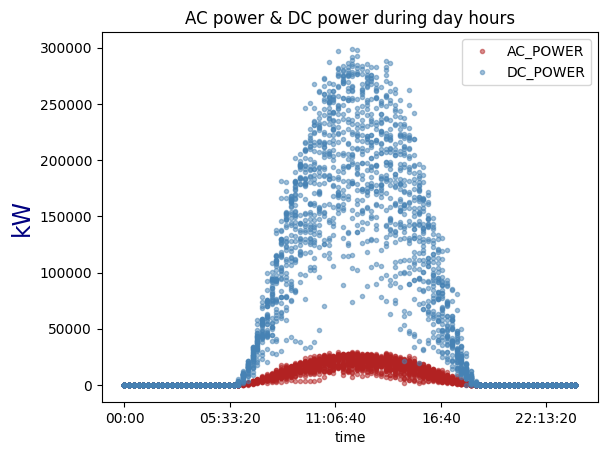

In [30]:
# Group the DataFrame data by the 'DATE_TIME' column and reset the DataFrame index
df_daily_gen = power_sensor.groupby('DATE_TIME').sum().reset_index()

# Create a new column 'time' in the DataFrame
df_daily_gen['time'] = df_daily_gen['DATE_TIME'].dt.time

# Remove the 'DATE_TIME' column from the DataFrame and set 'time' as the new index
df_daily_gen.set_index('time', inplace=True)
df_daily_gen.drop(columns=['DATE_TIME'], inplace=True)

# Plot AC_POWER and DC_POWER
ax = df_daily_gen[['AC_POWER', 'DC_POWER']].plot(style='.', color=["firebrick", 'steelblue'], alpha=0.5)
ax.set_title('AC power & DC power during day hours')
ax.set_ylabel('kW', color='navy', fontsize=17)

### Histograms

#### Module Tempearture

Text(0.5, 1.0, 'MODULE_TEMPERATURE Histogram')

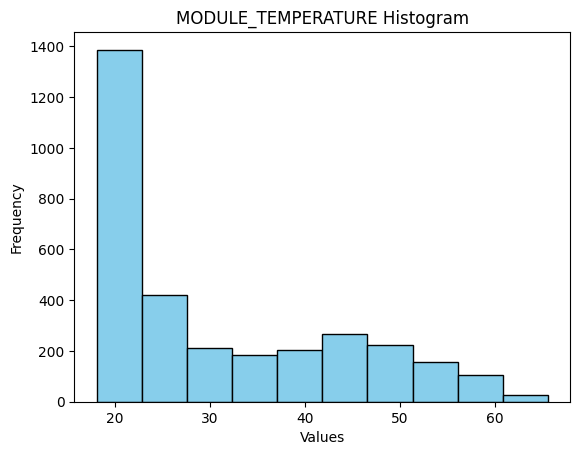

In [31]:
# Plotting the histogram
plt.hist(plant1_sensor['MODULE_TEMPERATURE'], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('MODULE_TEMPERATURE Histogram')

#### Daily Yield

Text(0.5, 1.0, 'DAILY_YIELD Histogram')

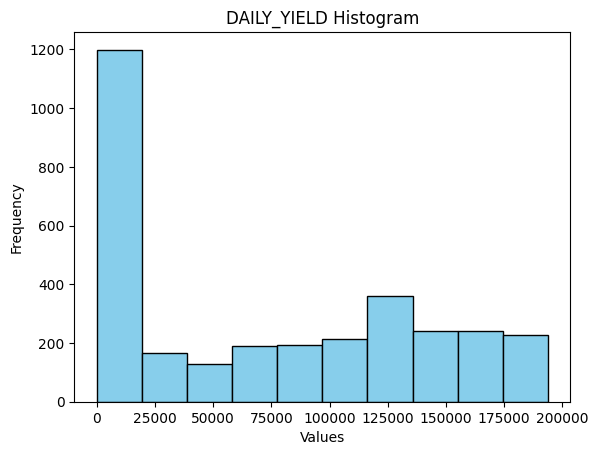

In [32]:
# Plotting the histogram
plt.hist(power_sensor['DAILY_YIELD'], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('DAILY_YIELD Histogram')

### Scatter Plot and Yield Mean
Plot the data points from the 'DAILY_YIELD' column against the 'time' column in the format of a scatter plot and plot the mean of daily yield on a line graph.

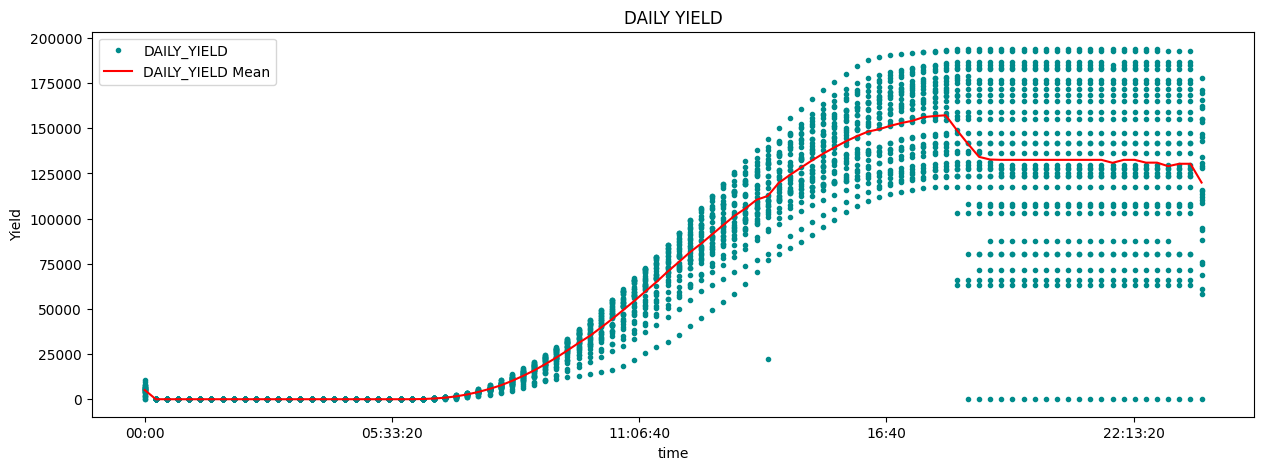

In [33]:
# Plot the 'DAILY_YIELD' column against the 'time' column of plant1_data
plant1_data.plot(x='time', y='DAILY_YIELD', style='.', color='darkcyan', figsize=(15, 5))

# Group the data by 'time' and calculate the mean of 'DAILY_YIELD' for each time
plant1_data.groupby('time')['DAILY_YIELD'].agg('mean').plot(legend=True,  label='DAILY_YIELD Mean', color='red')

# Set the title, labels and display the plot
plt.title('DAILY YIELD')
plt.ylabel('Yield')
plt.show()

### Scatter Plot and Mean MODULE_TEMPERATURE
Grafico que mostra MODULE_TEMPERATURE ao longo do dia e sua media no periodo total. Os pontos de MODULE_TEMPERATURE pode revelar a variabilidade diária, possíveis picos, anomalias ou períodos com falhas nos sensores. A linha mostra a Média de MODULE_TEMPERATURE agrupado por horario, o que ajuda a visualizar tendências de temperatura gerais e sazonalidade diária.

Text(0, 0.5, 'Temperature(°C)')

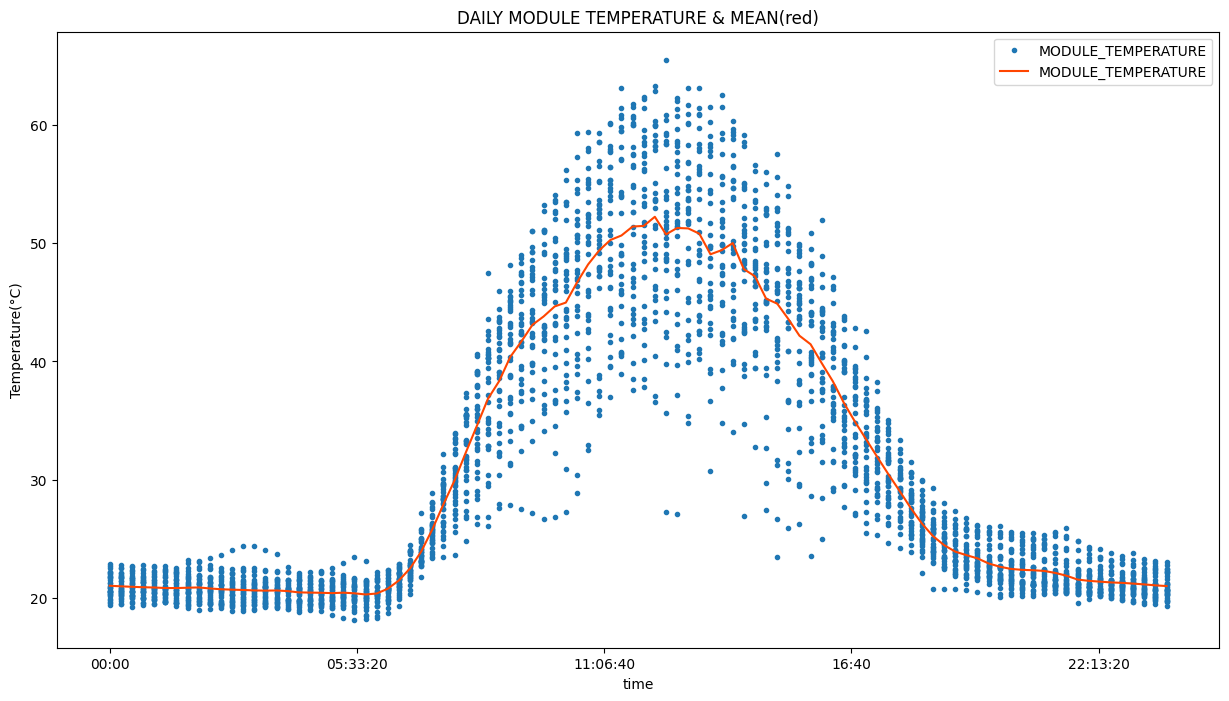

In [34]:
# Plot the 'MODULE_TEMPERATURE' column against the 'time' column of plant1_sensor
plant1_sensor.plot(x='time', y='MODULE_TEMPERATURE', figsize=(15, 8), style='.')

# Group the data by 'time' and calculate the mean of 'MODULE_TEMPERATURE' for each time,
# then plot the mean values as a line plot
plant1_sensor.groupby('time')['MODULE_TEMPERATURE'].agg('mean').plot(color='orangered', legend=True)

# Set the title and the labels
plt.title('DAILY MODULE TEMPERATURE & MEAN(red)')
plt.ylabel('Temperature(°C)')

### Training and Test Sets
#### Data Information
power_sensor is the DataFrame containing the merged data of power generation and temperature from the Solar Plant. These data will be used in the machine learning model.  
Para modelos como Regressão Linear e Random Forest aplicados a séries temporais, é fundamental preservar a ordem temporal na divisão dos dados.

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(power_sensor):
    train_data, test_data = power_sensor.iloc[train_index], power_sensor.iloc[test_index]

#### AC_POWER & DC_POWER
Não se deve usar AC_POWER como feature para prever DC_POWER porque elas são diretamente relacionadas, e isso poderia causar data leakage. Serão usados  características ambientais que afetam a geração de energia DC.

In [36]:
# Seleciona features e target
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'DC_POWER'

X = power_sensor[features]
y = power_sensor[target]

# Cria TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

#### Validação Cruzada - Linear Regression e Random Forest

In [37]:
# Loop de validação cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n=== Fold {fold+1} ===")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print(f"Linear Regression R²: {r2_score(y_test, y_pred_lr):.4f}")
    print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.4f}")
    print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


=== Fold 1 ===
Linear Regression R²: 0.9911
Linear Regression RMSE: 9291.01
Random Forest R²: 0.9940
Random Forest RMSE: 7657.51

=== Fold 2 ===
Linear Regression R²: 0.9915
Linear Regression RMSE: 8203.70
Random Forest R²: 0.9932
Random Forest RMSE: 7365.99

=== Fold 3 ===
Linear Regression R²: 0.9915
Linear Regression RMSE: 7993.96
Random Forest R²: 0.9934
Random Forest RMSE: 7025.59

=== Fold 4 ===
Linear Regression R²: 0.9865
Linear Regression RMSE: 9910.21
Random Forest R²: 0.9906
Random Forest RMSE: 8260.53

=== Fold 5 ===
Linear Regression R²: 0.9921
Linear Regression RMSE: 7406.09
Random Forest R²: 0.9953
Random Forest RMSE: 5723.81


#### Modelagem de Linear Regression

In [38]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

#### Modelagem Random Forest

In [39]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### ARIMA

In [41]:
series = power_sensor['DC_POWER']

# Split: 80% treino, 20% teste
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

#### Modelagem ARIMA

In [43]:
# Treinamento do modelo ARIMA(p,d,q)
model = ARIMA(train, order=(2,0,3))  # ajustar os parâmetros conforme necessário
model_fit = model.fit()

In [44]:
# Previsões no conjunto de test
forecast = model_fit.forecast(steps=len(test))

# Avaliação
rmse = mean_squared_error(test, forecast, squared=False)
print("ARIMA RMSE:", rmse)

ARIMA RMSE: 74770.96141701106


### Linear Regression
#### Actual Values vs. Predictions

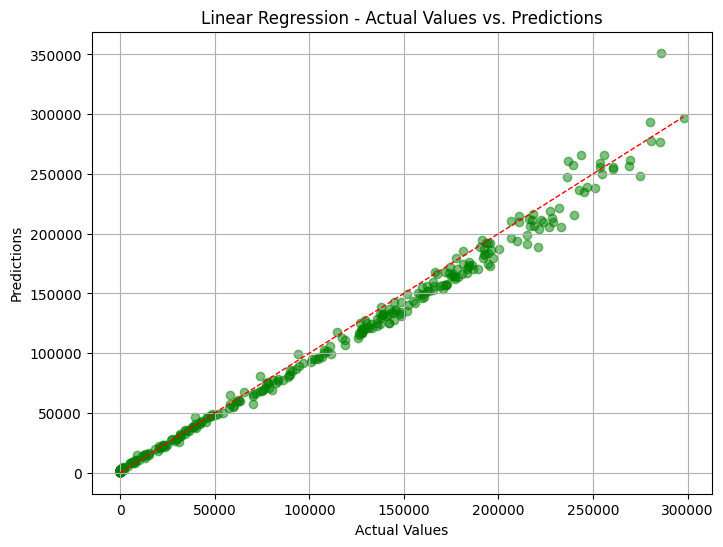

In [45]:
# Plotting actual values against predictions
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=y_pred_lr, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=1)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Linear Regression - Actual Values vs. Predictions')
plt.grid(True)
plt.show()

### Random Forest
#### Actual Values vs. Predictions

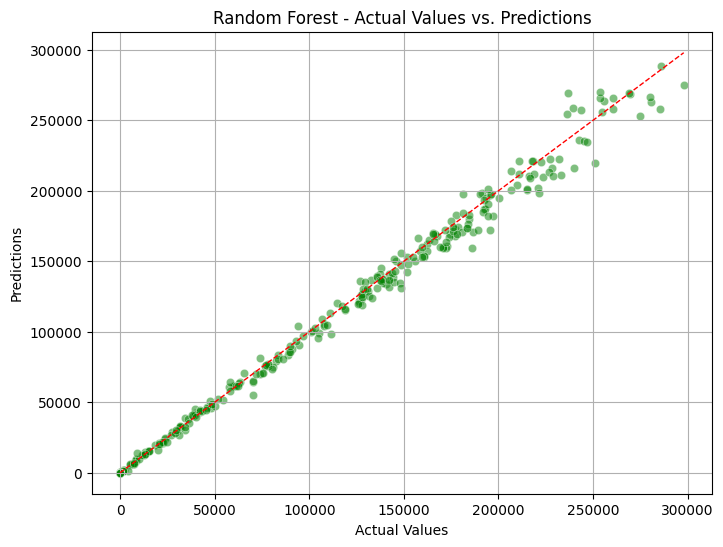

In [46]:
# Plotting actual values against predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=1)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Random Forest - Actual Values vs. Predictions')
plt.grid(True)
plt.show()

### ARIMA
#### Actual Values vs. Predictions

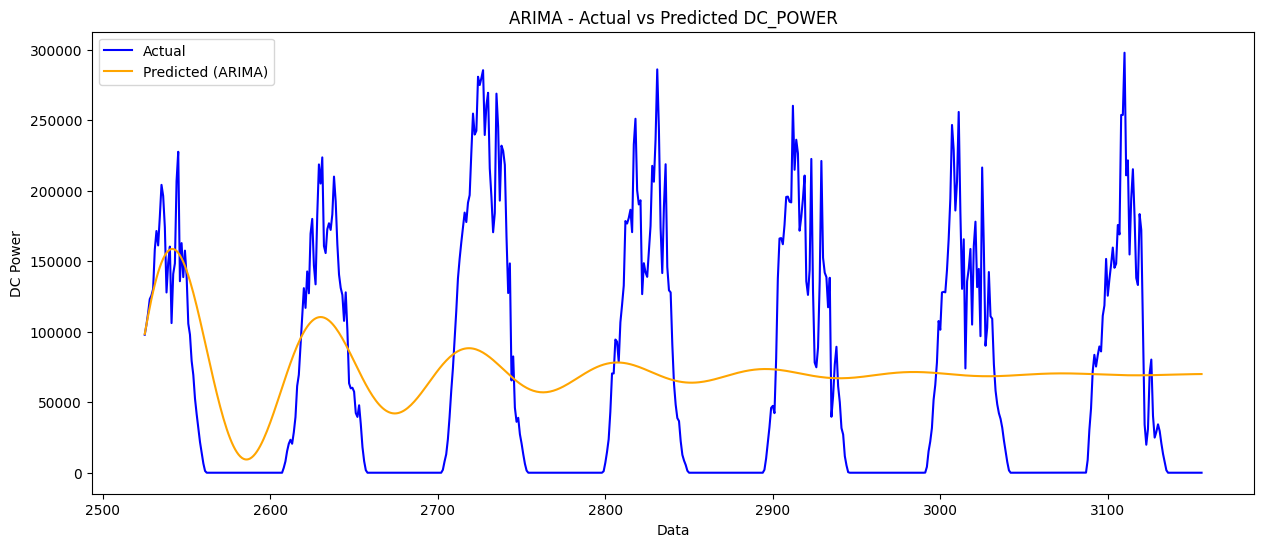

In [47]:
# Plotar actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted (ARIMA)', color='orange')
plt.title('ARIMA - Actual vs Predicted DC_POWER')
plt.xlabel('Data')
plt.ylabel('DC Power')
plt.legend()
plt.show()

### Análise por Modelo
#### Linear Regression
Também apresenta R² alto (≈0.99) e RMSE entre ~7400 e ~9900, o que é ótimo, embora um pouco inferior à Random Forest. Como é um modelo linear, tem limitações em capturar padrões complexos, mas ainda performa muito bem.  
#### Random Forest
Desempenho superior em todos os folds:  
R² entre 0.9906 e 0.9953, indicando excelente explicação da variância dos dados.  
RMSE consistentemente mais baixo, chegando a 5723.81 no melhor fold.  
Isso mostra que Random Forest está capturando bem relações não lineares e interações entre variáveis.  
#### ARIMA
RMSE muito mais alto: 74.770, mais de 10x pior que os modelos anteriores.  
Isso indica que, mesmo com o melhor parâmetro (2,0,3), o ARIMA não está conseguindo prever DC_POWER com boa acurácia.  
Provavelmente isso acontece porque o ARIMA não usa variáveis exógenas (como IRRADIATION ou TEMPERATURE) e foi feito sobre uma única série temporal, enquanto ML usa mais contexto.

### Conclusão da Analise
Random Forest é o melhor modelo para seu conjunto atual: mais robusto, menor erro, melhor capacidade de generalização.  
Linear Regression também é eficaz e mais simples de interpretar.  
ARIMA não é indicado nesse caso,ARIMA a série pode ser muito influenciada por variáveis exógenas ou não ter padrão temporal forte o suficiente para justificar o uso de ARIMA puro.